<a href="https://colab.research.google.com/github/mattiazanzi/NMA_latentDynamics_MZ/blob/main/Mattia_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

In [727]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [728]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [729]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [730]:
# REMOVE line below first time you run the colab 
# %%script echo skipping 

# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

## ============ **Data organisation** ==============

**Choose the target ROI**

In [769]:
# this function browses over the available recordings for a specified mouse, groups together the 
# available ROIs recorded across different days, and equates the number of available trials per neuron 
# within each ROI. importantly, the resulting units are selected according to two criteria: 
# 1: a stimulus with contrast>0 was presented to the screen
# 2: and, the mouse made a correct choice

def data_org(alldat, ROI_number=1, name='Cori', min_unit_num = 50, correct_resp=True):

    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex, ROI_number = 0
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus, ROI_number = 1
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal, ROI_number = 2
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex, ROI_number = 3
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain, ROI_number = 4
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia, ROI_number = 5
                    ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate, ROI_number = 6
                    ]

    ################################################################

    # first, group together the sessions corresponding to mouse name:

    mouse_ID_idx = [] # init

    for i in range(len(alldat)):
        # extract session indices for the specified mouse
        if alldat[i]['mouse_name']==name:
            mouse_ID_idx.append(i)   
    # isolate/store that mouse's sessions        
    curr_mouse = alldat[mouse_ID_idx] 

    ROI = brain_groups[ROI_number]

    ################################################################

    # second, filter the data according to the following criteria:
    #   - there is a 'visible' stimulus on the screen (i.e. contrast is not zero neither left/right) 
    #   - the mouse produced a correct response

    filtered_sessions = {}

    for session_ID in range(len(curr_mouse)): 

        filtered_ROIs = {} 

        for i in ROI:

            curr_ROI_data = curr_mouse[session_ID]["brain_area"]==i 
            curr_ROI_spikes = []
            curr_ROI_spikes = curr_mouse[session_ID]["spks"][curr_ROI_data] # isolate spikes given ROI

            # extract stim contrast values
            stim_values_left  = curr_mouse[session_ID]["contrast_left"]==0
            stim_values_right = curr_mouse[session_ID]["contrast_right"]==0
            # find the trials where the left AND the right stim contrast IS 0 (i.e. no stimulus has been presented on screen)
            where_null_contr = np.logical_and(stim_values_left, stim_values_right)
            where_stim_ON    = where_null_contr==False # boolean
        
            selected_trls = where_stim_ON

            if correct_resp:
                # extract trials where the mouce made a correct response
                correct_choice = curr_mouse[session_ID]["feedback_type"]==1
                selected_trls = np.logical_and(where_stim_ON, correct_choice)

            units_arr = np.empty((curr_ROI_spikes.shape[0], sum(selected_trls), curr_ROI_spikes.shape[2]), int) # init

            for neu in range(curr_ROI_spikes.shape[0]):
                units_arr[neu, :, :] = curr_ROI_spikes[neu, selected_trls, :]
            
            filtered_ROIs[i] = units_arr

        filtered_sessions[session_ID] = filtered_ROIs


    # init:
    ROI_data = {}
    days_to_sel = {}
    trls_to_sel = {}

    for i in filtered_sessions[session_ID]: # loop over ROI:

        # init
        sel_session = []
        sel_trls    = []

        # loop over available recorded sessions for mouse name:
        for session_ID in range(len(filtered_sessions)):  

            curr_ROI_spikes = filtered_sessions[session_ID][i] # isolate spikes given ROI

            # store how many units and trials-per-unit in the current session:
            num_of_units  = curr_ROI_spikes.shape[0]
            num_of_trials = curr_ROI_spikes.shape[1]

            # if there are units in current ROI: 
            if num_of_units>0:

                sel_session.append(session_ID)
                sel_trls.append(num_of_trials)

                days_to_sel[i] = sel_session
                trls_to_sel[i] = sel_trls


    units_selector = {} # init

    # extract the minimum number of trials for each group of ROIs:
    for key in trls_to_sel:
        units_selector[key] = days_to_sel[key], min(trls_to_sel[key])

    ROI_data = {} # init

    for key in units_selector: # loop over available ROIs:
        
        # init
        units_arr = np.empty((0, units_selector[key][1], 250), int)

        # loop over 'survived' sessions:
        for session in units_selector[key][0]:

            # isolate spikes given ROI
            curr_ROI_spikes = filtered_sessions[session][key]
            curr_ROI_spikes = curr_ROI_spikes[:, :units_selector[key][1], :]

            units_arr = np.append(units_arr, curr_ROI_spikes, axis=0) # group together trials for current ROI 
        
        # include according to n. of neurons threshold
        if units_arr.shape[0]>min_unit_num:
            ROI_data[key] = units_arr # fill new dict

    return ROI_data     

**Define functions for trial clustering (with overlapping or not-overlapping clustering windows)**

In [732]:
# Convert signal into frequency by averaging activity across n trials

def no_overlap_frequency(ROI_data, n_aver_trials=5, time_bin = 0.01):

  spike_frequency = {}

  for key in ROI_data:
      curr_data = ROI_data[key]

      n_trl = curr_data.shape[1]
      n_new_trl = n_trl  // n_aver_trials
      
      # Ensure that if you have a big remainder at the end 
      # you compute the mean of that remainder and add it as a final trial

      remainder =  n_trl - n_new_trl * n_aver_trials

      if  remainder >= n_aver_trials-2:
          frequency_spk = np.zeros((curr_data.shape[0],n_new_trl + 1,curr_data.shape[2]))
          sub_data = curr_data[:,n_new_trl:]
          frequency_spk[:,-1:] = np.mean(sub_data, axis= 1, keepdims=True) / time_bin

      else:
          frequency_spk = np.zeros((curr_data.shape[0],n_new_trl,curr_data.shape[2])) 

      indexes = np.arange(0,n_trl ,n_aver_trials)

      t = 0
      for i in indexes[:-1]:
          sub_data = curr_data[:,i:indexes[t+1]]
          frequency_spk[:,t:t+1] = np.mean(sub_data, axis= 1, keepdims=True) / time_bin
          t+=1
          
      spike_frequency[key] = frequency_spk


  return spike_frequency

In [733]:
# Sliding averaged window:

def overlapping_frequency(ROI_data, n_overlapping_trials=100, time_bin = 0.01):

    spike_rate = {}

    for key in ROI_data:
        curr_data = ROI_data[key]
        
        area = curr_data

        window_len = n_overlapping_trials # in trials

        last_step  = area.shape[1] - window_len
        step_range = (np.arange(0, last_step, 1))

        # init
        rate_spk = np.zeros((area.shape[0], last_step, area.shape[2]))  

        # loop over neurons
        for n in range(0, area.shape[0]):
        
            # slide trial window
            for p in step_range:

                # compute average and fill spike rate matrix
                for x in range(0, area.shape[1], window_len):
                    trial_avg = area[n, np.arange(p, p+window_len, 1), :].mean(axis=0)
                    trial_avg = trial_avg/time_bin # time average
                    rate_spk[n,p,:] = trial_avg 
        
        spike_rate[key] = rate_spk

    return spike_rate

**Prune and equate seed and prediction ROIs to have them the same size**

In [770]:
# prune/equate ROIs according to minimum number of units and neurons

def data_pruning(seed_ROI, pred_ROI):

    how_many_units  = []
    how_many_trials = []

    # find minimum number of units and trials in the seed ROI:
    for key in seed_ROI:

        how_many_units.append(seed_ROI[key].shape[0])
        how_many_trials.append(seed_ROI[key].shape[1])

    min_units_seed = min(how_many_units)
    min_trial_seed = min(how_many_trials)

    how_many_units  = []
    how_many_trials = []

    # find minimum number of units and trials in the predicted ROI:
    for key in pred_ROI:

        how_many_units.append(pred_ROI[key].shape[0])
        how_many_trials.append(pred_ROI[key].shape[1])

    min_units_pred= min(how_many_units)
    min_trial_pred= min(how_many_trials)

    min_units = min(min_units_seed, min_units_pred)
    min_trial = min(min_trial_seed, min_trial_pred)

    pruned_seed = {}
    pruned_pred = {}

    # prune random units and trials in the SEED ROI according to min_units and min_trial:
    for key in seed_ROI:

        curr_units_num = seed_ROI[key].shape[0]
        curr_trial_num = seed_ROI[key].shape[1]

        rand_sel_units = np.random.randint(0, high=curr_units_num, size=min_units)
        rand_sel_trial = np.random.randint(0, high=curr_trial_num, size=min_trial)

        seed_sel_units = seed_ROI[key][rand_sel_units, :, :]
        seed_sel_units = seed_sel_units[:, rand_sel_trial, :]

        pruned_seed[key] = seed_sel_units

    # prune random units and trials in the PREDICTED ROI according to min_units and min_trial:
    for key in pred_ROI:

        curr_units_num = pred_ROI[key].shape[0]
        curr_trial_num = pred_ROI[key].shape[1]

        rand_sel_units = np.random.randint(0, high=curr_units_num, size=min_units)
        rand_sel_trial = np.random.randint(0, high=curr_trial_num, size=min_trial)

        pred_sel_units = pred_ROI[key][rand_sel_units, :, :]
        pred_sel_units = pred_sel_units[:, rand_sel_trial, :]

        pruned_pred[key] = pred_sel_units

    return pruned_seed, pruned_pred

## ============ **Extract and prepare the data** ==============

**Choose the target ROI**

In [780]:
# Load the data:

ROI_n_seed = 0 # seed ROI
ROI_n_pred = 0 # predicted ROI
mouse_name = 'Cori'

# DEFINE PARAMS:

# ROI_number: 
# 0 = visual cortex
# 1 = thalamus
# 2 = hippocampus 
# 3 = other cortices 
# 4 = midbrain 
# 5 = basal ganglia
# 6 = cortical subplate 
# 7 = other regions

# mouse_name, chose among Cori, Forssmann, Hench, Lederberg, Moniz, Muller, Radnitz, Richards, Tatum, Theiler

# correct_resp: True=choose only trials when the mouse made a correct response, False=correct and failures

# min_unit_num: include only the ROI with >min_unit_num number of units

seed_ROI = data_org(alldat, ROI_number = ROI_n_seed, name=mouse_name, min_unit_num=50, correct_resp=True)
pred_ROI = data_org(alldat, ROI_number = ROI_n_pred, name=mouse_name, min_unit_num=50, correct_resp=True)

# prune and equate seed and prediction regions so that they match in shape
seed_ROI, pred_ROI = data_pruning(seed_ROI=seed_ROI, pred_ROI=pred_ROI)

# Initialise some useful variables for data extraction/organisation:

time_bin = 0.01 # DON'T CHANGE, given by the experiment

overlapping_trials = True
n_overlapping_tr = 30
n_nonOverlap_tr  = 15

subtract_baseline = True

# Decide if want to use overlapping trials to compute frequency or not:

if overlapping_trials == True:
  spike_rate_seed = overlapping_frequency(seed_ROI, n_overlapping_trials=n_overlapping_tr, time_bin=time_bin)
  spike_rate_pred = overlapping_frequency(pred_ROI, n_overlapping_trials=n_overlapping_tr, time_bin=time_bin)
  print("Overlapping data")
else:
  spike_rate_seed = no_overlap_frequency(seed_ROI, n_aver_trials=n_nonOverlap_tr, time_bin=time_bin)
  spike_rate_pred = no_overlap_frequency(pred_ROI, n_aver_trials=n_nonOverlap_tr, time_bin=time_bin)
  print("No overlapping data") 


Overlapping data


**Baseline-normalize the data and prepare them for training the RNN (split neurons in train/test groups)**

In [781]:
# Remove baseline and baseline-normalise the training/seed data

baseline_end = 50

training_nn_seed = {}
testing_nn_seed  = {}

# baseline-normalize SEED ROI:
for key in spike_rate_seed:

    curr_trls = spike_rate_seed[key]
    baseline_mean = curr_trls[:,:,0:baseline_end].mean(axis=2, keepdims=True) 
    bas_norm_seed = curr_trls[:,:,baseline_end:]

    # Subtract baseline from signal to improve data
    if subtract_baseline:

        bas_norm_seed -= baseline_mean
        bas_norm_seed = np.maximum(0, bas_norm_seed)

    n_of_units = int(np.floor(bas_norm_seed.shape[0]/2))

    training_nn_seed[key] = bas_norm_seed[:n_of_units, :, :]   
    testing_nn_seed[key]  = bas_norm_seed[n_of_units+1:, :, :]

# equate number of units for the training/testing sets:
if training_nn_seed[key].shape[0]!=testing_nn_seed[key].shape[0]: 
    min_units = min(training_nn_seed[key].shape[0], testing_nn_seed[key].shape[0])
    for key in training_nn_seed: 
        training_nn_seed[key] = training_nn_seed[key][:min_units, :, :]
        testing_nn_seed[key]  = testing_nn_seed[key][:min_units, :, :]


**Plot average seed ROI activity:**

SEED ROI


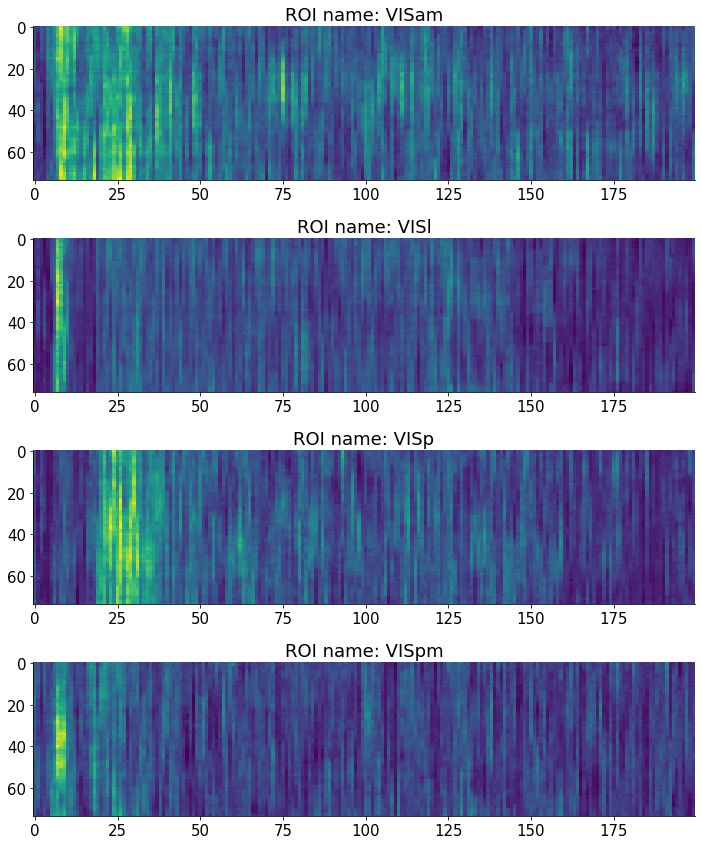

In [782]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

curr_ROIs_name = list(training_nn_seed)

scaling = int(15/len(curr_ROIs_name))*len(curr_ROIs_name)

plt.figure(figsize=(10, scaling))
plt.subplots_adjust(hspace=1)

for n in range(len(curr_ROIs_name)):

    curr_ROI = training_nn_seed[curr_ROIs_name[n]].mean(axis=0)
    
    # add a new subplot iteratively
    plt.subplot(len(curr_ROIs_name), 1, n+1)
    plt.imshow(curr_ROI, interpolation='nearest', aspect='auto')
    plt.title('ROI name: {region}'.format(region=curr_ROIs_name[n]))

print('SEED ROI')
    

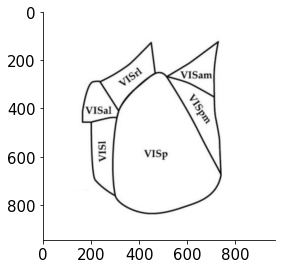

In [738]:
# if ROI is Visual Cortex

if ROI_n_seed==0:

    img=mpimg.imread('/Users/mattiazanzi/Desktop/mouse_V1.png')
    imgplot = plt.imshow(img)

## ============ **Define and train the RNN** ==============

In [739]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

**Define the RNN**

In [740]:
class Net(nn.Module):
  
  def __init__(self, ncomp, NN1, NN2, lr=.005, loss_type= 2, bidi=True, batch_size=30):
    
    super(Net, self).__init__()

    self.batch_size = batch_size

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'relu')
    self.fc = nn.Linear(ncomp, NN2)

    self.ncomp = ncomp
    
    self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()

    self.loss_type = loss_type

  
  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :self.ncomp] + y[:, :, self.ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q
  
  def Poisson_loss_update(self, lam, spk):

    loss = torch.mean(lam - spk * torch.log(lam))
    return loss


  def train(self, input, target, niter=1000):

      # special thing:  we initialize the biases of the last layer in the neural network
      # we set them as the mean firing rates of the neurons.
      # this should make the initial predictions close to the mean, because the latents don't contribute much
      self.fc.bias.data[:] = input.mean((0,1))

      max_n_trials = input.shape[1]

      overall_cost = []
      
      for k in range(niter):
        
          batch_indx = torch.randint(0, max_n_trials, (self.batch_size,))
          x = input[:,batch_indx,:]
          # the network outputs the single-neuron prediction and the latents
          y_hat, h = self(x)

          y_tar = target[:,batch_indx,:]
      
          if self.loss_type == 1:
              # train the network with Poisson log-likelihood cost
              loss = self.Poisson_loss_update(y_hat, y_tar)
          
          elif self.loss_type == 2:
              # train the network with L2 cost
              loss = self.loss(y_hat, y_tar)

          overall_cost.append(loss)
          
          loss.backward()
          self.optimizer.step()
          self.optimizer.zero_grad()

          if k % 100 == 0:
            print(f'iteration {k}, cost {loss.item():.4f}')

      return overall_cost
    


In [741]:
# Initialise RNN

n_iterations = 20000
ln_rate = 0.0005
loss_type = 2 # 1: Poisson, 2: L2
ncomp = 20
deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**Choose the training ROI**

In [742]:
# choose your seed region
print(training_nn_seed.keys())

dict_keys(['VISam', 'VISl', 'VISp', 'VISpm'])


In [743]:
seed_name = 'VISl' # train on this region

**Train the network**

In [744]:
# Define RNN for training

if deterministic:
   torch.manual_seed(0)

seed_training_nn = torch.tensor(training_nn_seed[seed_name], device=device).float()

# Put them in the right shape for the RNN
tr_nn = torch.permute(seed_training_nn,(2,1,0)) # time x trial x units
NN1 = tr_nn.shape[-1]

# store parameters
net = Net(ncomp, NN1, NN1, lr=ln_rate, loss_type=loss_type, bidi=True).to(device) # .0005

# train!
overall_cost = net.train(tr_nn, tr_nn, niter = n_iterations)


iteration 0, cost 9.1545
iteration 100, cost 6.5815
iteration 200, cost 3.9629
iteration 300, cost 2.7129
iteration 400, cost 2.2869
iteration 500, cost 1.8299
iteration 600, cost 1.6162
iteration 700, cost 1.4090
iteration 800, cost 1.2786
iteration 900, cost 1.2539
iteration 1000, cost 1.1246
iteration 1100, cost 1.1041
iteration 1200, cost 1.0471
iteration 1300, cost 1.0069
iteration 1400, cost 0.9460
iteration 1500, cost 0.9058
iteration 1600, cost 0.8723
iteration 1700, cost 0.8685
iteration 1800, cost 0.8432
iteration 1900, cost 0.8179
iteration 2000, cost 0.8167
iteration 2100, cost 0.8128
iteration 2200, cost 0.7668
iteration 2300, cost 0.7914
iteration 2400, cost 0.7200
iteration 2500, cost 0.7330
iteration 2600, cost 0.6906
iteration 2700, cost 0.6891
iteration 2800, cost 0.6855
iteration 2900, cost 0.6393
iteration 3000, cost 0.6766
iteration 3100, cost 0.6679
iteration 3200, cost 0.6499
iteration 3300, cost 0.6357
iteration 3400, cost 0.6394
iteration 3500, cost 0.6380
iter

**Store and visualize the loss**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

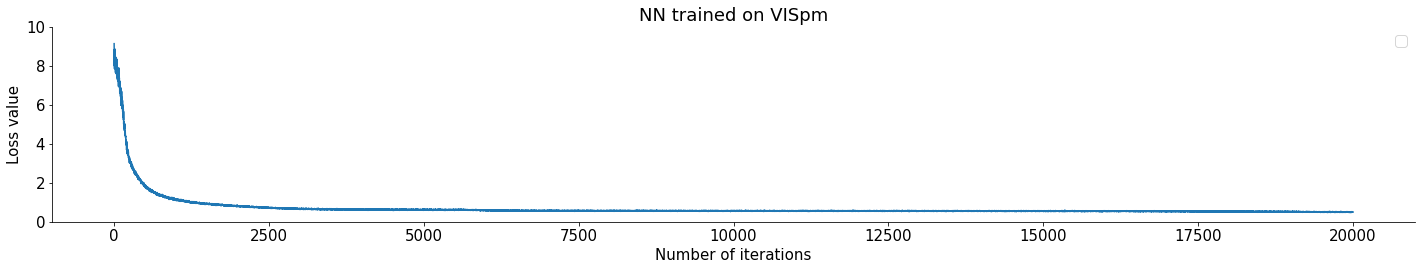

In [745]:
# store loss values

retained_losses = {}

curr_loss = np.zeros([len(overall_cost), 1])

for i in range(len(overall_cost)):
  curr_loss[i] = overall_cost[i].detach().numpy()

retained_losses[seed_name] = curr_loss

###########

# plot loss: 

plt.plot(retained_losses[seed_name])
plt.legend(loc='best')
plt.title("NN trained on {Te_t}".format(Te_t=key))
plt.ylabel('Loss value')
plt.xlabel('Number of iterations')
plt.ylim([0, int(max(retained_losses[seed_name]))+1])

plt.show

## ============ **Test prediction on the testing set of the same ROI** ==============

/var/folders/q6/52_pbzr12q33bsd0132n1tj00000gn/T/ipykernel_19172/4181528172.py:15: RuntimeWarning: invalid value encountered in true_divide
  orig_test_nn_numpy = orig_test_nn_numpy / np.max(orig_test_nn_numpy, axis=0)


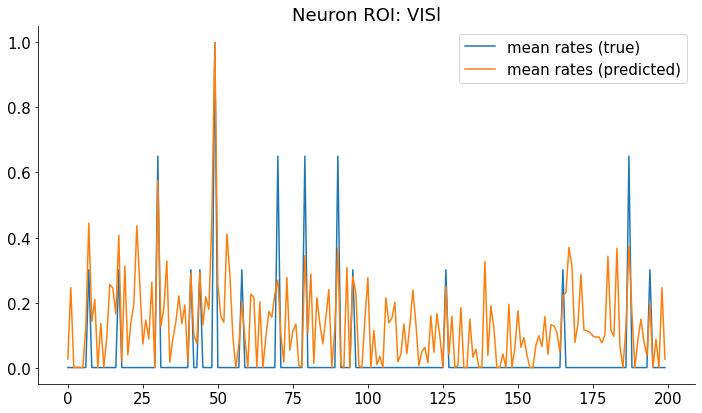

In [746]:
# test prediction on the same area

predict_test_seed = torch.tensor(testing_nn_seed[seed_name], device=device).float() # prepare testing-set tensor
test_nn = torch.permute(predict_test_seed, (2,1,0)) # time x trial x unit number

# make prediction
y_hat, _ = net(test_nn)
y_hat_np = y_hat.detach().cpu().numpy()
y_hat_np = y_hat_np / np.max(y_hat_np, axis=0)
predicted_seed = y_hat_np # actual prediction to be compared with original activity


# prepare the original test data for visual inspection
orig_test_nn_numpy = test_nn.detach().cpu().numpy()
orig_test_nn_numpy = orig_test_nn_numpy / np.max(orig_test_nn_numpy, axis=0)

###############################################################

# plot

ex_nn = 11
ex_trial_n = 18

plt.figure(figsize=(10, 6))
plt.plot(orig_test_nn_numpy[:, ex_trial_n, ex_nn])
plt.plot(predicted_seed[:, ex_trial_n, ex_nn])

plt.legend(['mean rates (true)', 'mean rates (predicted)', 'spikes'])
plt.title("Neuron ROI: {Te_t}".format(Te_t=seed_name))
plt.show()


## ============ **Test prediction on a different ROI** ==============

In [747]:
# Remove baseline and baseline-normalise the data

baseline_end = 50

testing_nn_pred  = {}

# baseline-normalize SEED ROI:
for key in spike_rate_pred:

    curr_trls = spike_rate_pred[key]
    baseline_mean = curr_trls[:,:,0:baseline_end].mean(axis=2, keepdims=True) 
    bas_norm_pred = curr_trls[:,:,baseline_end:]

    # Subtract baseline from signal to improve data
    if subtract_baseline:

        bas_norm_pred -= baseline_mean
        bas_norm_pred = np.maximum(0, bas_norm_pred)

    n_of_units = int(np.floor(bas_norm_pred.shape[0]/2))
    testing_nn_pred[key]  = bas_norm_pred[n_of_units+1:, :, :]

# equate number of units for the training/testing sets:
if training_nn_seed[seed_name].shape[0]!=testing_nn_pred[key].shape[0]: 
    min_units = min(training_nn_seed[seed_name].shape[0], testing_nn_pred[key].shape[0])
    testing_nn_pred[key]  = testing_nn_pred[key][:min_units, :, :]


**Plot average prediction ROI activity:**

PREDICTION ROI


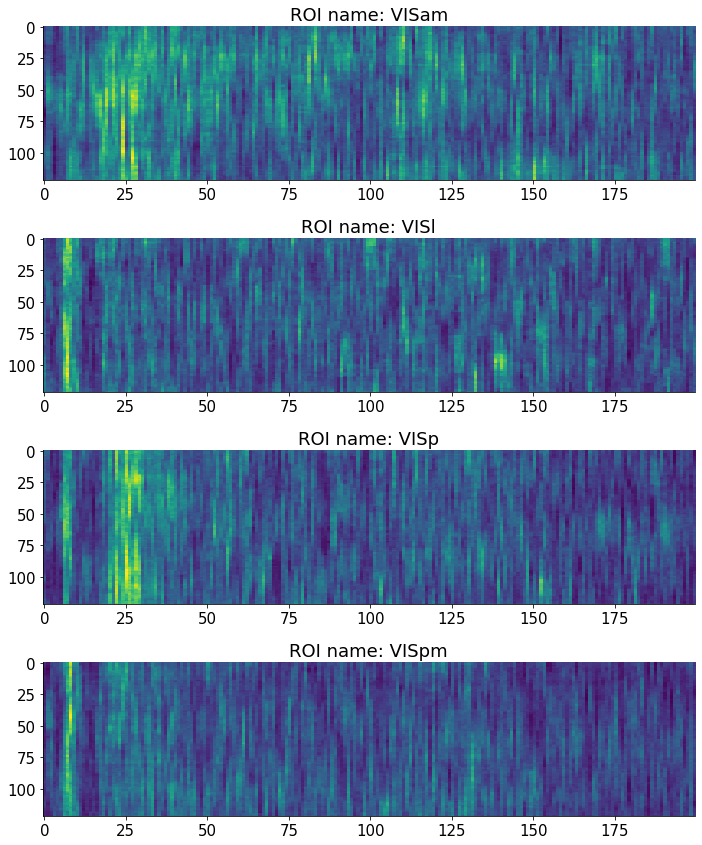

In [748]:
curr_ROIs_name = list(testing_nn_pred)

scaling = int(15/len(curr_ROIs_name))*len(curr_ROIs_name)

plt.figure(figsize=(10, scaling))
plt.subplots_adjust(hspace=1)

for n in range(len(curr_ROIs_name)):

    curr_ROI = testing_nn_pred[curr_ROIs_name[n]].mean(axis=0)
    
    # add a new subplot iteratively
    plt.subplot(len(curr_ROIs_name), 1, n+1)
    plt.imshow(curr_ROI, interpolation='nearest', aspect='auto')
    plt.title('ROI name: {region}'.format(region=curr_ROIs_name[n]))

print('PREDICTION ROI')

**Choose the target ROI**

In [749]:
for key in spike_rate_pred:
    print(key)

VISam
VISl
VISp
VISpm


/var/folders/q6/52_pbzr12q33bsd0132n1tj00000gn/T/ipykernel_19172/3165381108.py:16: RuntimeWarning: invalid value encountered in true_divide
  orig_test_nn_numpy = orig_test_nn_numpy / np.max(orig_test_nn_numpy, axis=0)


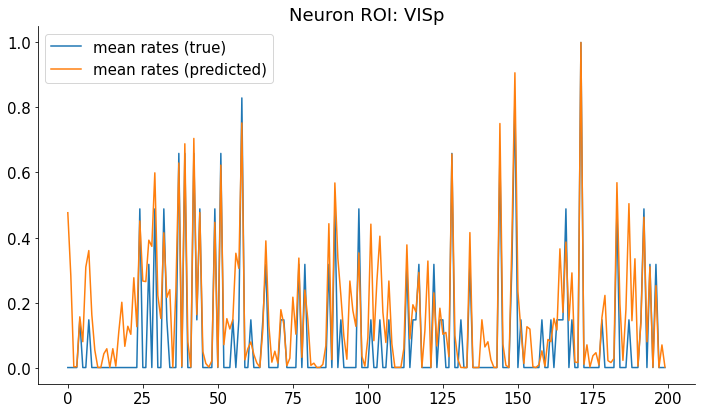

In [750]:
# test prediction on other areas

test_name = 'VISp' # test on this region

predict_test_pred  = torch.tensor(testing_nn_pred[test_name], device=device).float()
tests_nn = torch.permute(predict_test_pred,(2,1,0))

# make prediction
y_hat, _ = net(tests_nn)
y_hat_np = y_hat.detach().cpu().numpy()
y_hat_np = y_hat_np / np.max(y_hat_np, axis=0)
predicted_pred = y_hat_np # actual prediction to be compared with original activity

# prepare the original test data for visual inspection
orig_test_nn_numpy = tests_nn.detach().cpu().numpy()
orig_test_nn_numpy = orig_test_nn_numpy / np.max(orig_test_nn_numpy, axis=0)

###############################################################

# plot

ex_nn = 11
ex_trial_n = 1

plt.figure(figsize=(10, 6))
plt.plot(orig_test_nn_numpy[:, ex_trial_n, ex_nn])
plt.plot(predicted_pred[:, ex_trial_n, ex_nn])

plt.legend(['mean rates (true)', 'mean rates (predicted)', 'spikes'])
plt.title("Neuron ROI: {Te_t}".format(Te_t=test_name))
plt.show()

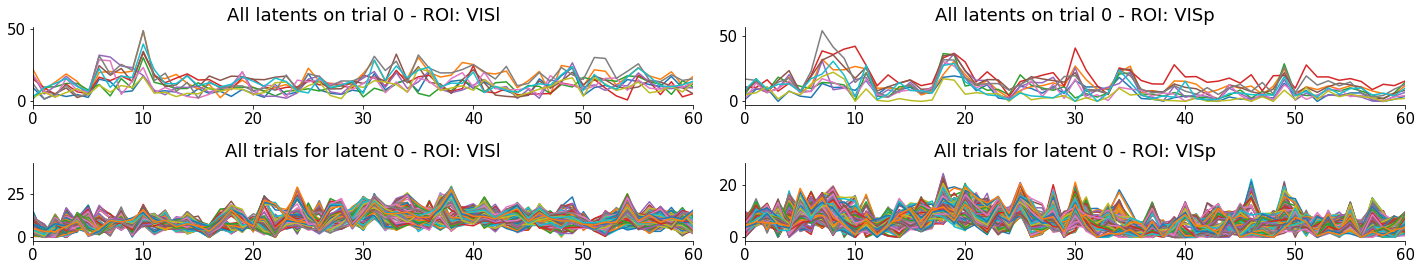

In [751]:
# Plot latent space

latent = 0

_, h_seed = net(tr_nn)
_, h_pred = net(test_nn)

hseed_cpu = h_seed.detach().cpu().numpy()
hpred_cpu = h_pred.detach().cpu().numpy()

plt.figure(figsize=(20, 4))

plt.subplot(221)
for c in np.arange(0,10):
  plt.plot(hseed_cpu[:, latent, c], label = c);
plt.title('All latents on trial {Te_t} - ROI: {roi}'.format(Te_t=latent, roi=seed_name))
plt.xlim(0,60)

plt.subplot(222)
for c in np.arange(0,10):
  plt.plot(hpred_cpu[:, latent, c], label = c);
plt.title('All latents on trial {Te_t} - ROI: {roi}'.format(Te_t=latent, roi=test_name))
plt.xlim(0,60)

plt.subplot(223)
plt.plot(hseed_cpu[:, :, latent]);
plt.title('All trials for latent {Te_t} - ROI: {roi}'.format(Te_t=latent, roi=seed_name))
plt.xlim(0,60)

plt.subplot(224)
plt.plot(hpred_cpu[:, :, latent]);
plt.title('All trials for latent {Te_t} - ROI: {roi}'.format(Te_t=latent, roi=test_name))
plt.xlim(0,60)
plt.show()

